In [1]:
!pip install --upgrade pandas numpy dask black[jupyter] uproot3 pyarrow astropy

In [2]:
import uproot3

import dask.dataframe as dd
import pandas as pd
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from dataclasses import dataclass

%matplotlib inline

In [3]:
!ls -lah *.root

-rw-rw-r-- 1 jovyan users 76M May 24 22:29 data00.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:29 data01.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:29 data02.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:29 data03.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:29 data04.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data05.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data06.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data07.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data08.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data09.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data10.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data11.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data12.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data13.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data14.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:30 data15.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:31 data16.root
-rw-rw-r-- 1 jovyan users 76M May 24 22:31 data17.root
-rw-rw-r--

In [4]:
import scat

In [5]:
input_files = !ls data*.root

In [6]:
dask_dataframe = dd.from_map(scat.read_root_file, input_files)

In [7]:
scat.dask_memory_usage_GB(dask_dataframe)

3.07336688041687

In [8]:
centroids, histogram = scat.dask_histogram(
    dask_dataframe, "value1", bins=20, bins_range=[-5, 5]
)

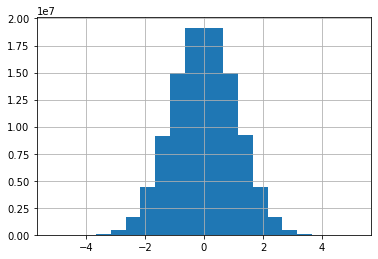

In [9]:
plt.bar(centroids, histogram)
plt.grid();

In [10]:
from scat.filters import ComputeColumn, QueryFilter

In [11]:
ComputeColumn??

Init signature: ComputeColumn(column_1: str, column_2: str) -> None
Docstring:      ComputeColumn(column_1: str, column_2: str)
Source:        
class ComputeColumn:
    column_1: str
    column_2: str

    def __call__(self, df):
        df = df.assign(computed_col=(df[self.column_1] + df[self.column_2])) ** 2
        return df
File:           ~/reusablepipeline/scat/filters.py
Type:           type
Subclasses:     


In [12]:
func = ComputeColumn("value1", "value2")

In [13]:
dask_dataframe_added_column = dask_dataframe.map_partitions(func)

In [14]:
QueryFilter??

Init signature: QueryFilter(query: str) -> None
Docstring:      QueryFilter(query: str)
Source:        
class QueryFilter:
    query: str

    def __call__(self, df):
        return df.query(self.query)
File:           ~/reusablepipeline/scat/filters.py
Type:           type
Subclasses:     


In [15]:
filt = QueryFilter("computed_col < 1")

In [16]:
dask_dataframe_added_column_filtered = dask_dataframe_added_column.map_partitions(filt)

In [17]:
output_pandas_dataframe = dask_dataframe_added_column_filtered.compute()

In [18]:
output_pandas_dataframe.head()

,seriesNumber,eventNumber,detNumber,value1,value2,computed_col
0,0,0,9,0.025411,0.161719,0.315340
1,0,0,4,1.186726,0.139076,0.513287
2,0,0,1,0.140486,1.308061,0.591192
3,0,0,1,0.319691,1.230156,0.295623
4,0,0,9,0.250476,0.729173,0.124920


In [19]:
len(output_pandas_dataframe) / 1e6

52.045638

## Use the configuration files

In [20]:
%%file filters/datasetname/compute_squaredsum.toml

class = "ComputeColumn"
column_1 = "value1"
column_2 = "value2"

Overwriting filters/datasetname/compute_squaredsum.toml


In [21]:
%%file filters/datasetname/filter_computedcol.toml

class = "QueryFilter"
query = "computed_col < 1"

Overwriting filters/datasetname/filter_computedcol.toml


In [22]:
%%file filters/datasetname/dataset_pipeline.toml

class = "Pipeline"
steps = ["filters/datasetname/compute_squaredsum.toml", "filters/datasetname/filter_computedcol.toml"]

Overwriting filters/datasetname/dataset_pipeline.toml


In [24]:
compute_squaredsum = load_filter("filters/datasetname/compute_squaredsum.toml")

In [26]:
dask_dataframe.map_partitions(compute_squaredsum).head()

,seriesNumber,eventNumber,detNumber,value1,value2,computed_col
0,0,0,9,0.025411,0.161719,0.315340
1,0,0,4,1.186726,0.139076,0.513287
2,0,0,1,0.140486,1.308061,0.591192
3,0,0,1,0.319691,1.230156,0.295623
4,0,0,9,0.250476,0.729173,0.124920
